# Processing and analysis of data of raw fltrace traces

## 0. Prerequisites
1. The traces obtained using `fltrace record -M <M_value> -L <L_value> -- program_name`. The parent folder of the traces is designed in the `PARENT_FOLDER_PATH` constant. Inside the parent folder should be several children folders named after benchmark/program traced. Inside each children folder should be grandchildren folders, one per each `(M,L)` pair. Then, inside each grandchildren folder should be the output files of fltrace, that is `fltrace-data-faults*.out`, `fltrace-data-procmaps*.out`, and (optionally) `fltrace-data-stats*.out`. 

    One example hierarchy is 

    ```
    parent/                                   
    ├── canneal/                              
    ┆   ├──200_50/                            
    ┆   ┆   ├──fltrace-data-faults-56090-1.out
    ┆   ┆   ├──fltrace-data-procmaps-56090.out
    ┆   ┆   └──fltrace-data-stats-56090.out   
    ┆   ├──200_100/                           
    ┆   ┆   ├──fltrace-data-faults-55308-1.out
    ┆   ┆   ├──fltrace-data-procmaps-55308.out
    ┆   ┆   └──fltrace-data-stats-55308.out   
    ┆   ├──200_150/                           
    ┆   ┆   ├──...                            
    ┆   └──200_200/                           
    ┆       ├──...                            
    └── fludanimate/                          
        ├──...                                
    ```
    See [the fltrace guide](../data/fltrace.md) to get information about how to get `fltrace` running, as well as how to extend/fix it to get more data. 

2. The objectdumps (`objdump -d /path/to/lib_or_executable_name > lib_or_executable_name`) of all relevant librairies accessed by the traced programs. The folder containing all the objdumps is designed in the `OBJDUMP_FOLDER_PATH` constant. That is, if a library/executable is present in one of the `procmaps` of one of the trace runs, its objdump should be in this directory.

    One example hierarchy is 

    ```
    objdumps/               
    ├── canneal             
    ├── fludanimate         
    ├── fltrace.so          
    ├── ld-linux-x86-64.so.2
    ├── libc.so.6           
    ├── libgcc_s.so.1       
    ├── libm.so.6           
    └── libstdc++.so.6.0.30 
    ```


### Constants & imports

In [1]:
from tokenize import group

import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
from collections import defaultdict
from pathlib import Path
import swifter # used even though marked as unused, do not delete 
from utils.fltrace_classes import *
from utils.constants import *
from plotters import plotter
import matplotlib.pyplot as plt
import functools as ft
import math
from itertools import chain

In [3]:
PARENT_FOLDER_PATH = "../data/parsec_raw_out/"
OBJDUMP_FOLDER_PATH = "../data/objdumps/"
TEXT_SEPARATOR = '_'*30

# I. Pre-processing of the trace(s)

First, let us confirm that we have the correct directory tree, as defined in the prerequisites. Let's start by checking that the `objdump` looks correct. Note that we can't do extensive check before reading through the procmaps, which we will do at a later stage.

In [4]:
def __check_correct_dir(path: Path, str_path: str = ""):
    assert path.exists() and path.is_dir(),("The directory "+ (f"{str_path}, a.k.a. " if str_path != "" else "") +f"{path.absolute().as_posix()} either does not exist, or isn't a directory")
    
def check_correct_dir(str_path: str):
    path = Path(str_path)
    __check_correct_dir(path)
    
check_correct_dir(OBJDUMP_FOLDER_PATH)

Then, let's look at the traces data. We take the opportunity of traversing the tree of path to load the relevant data, depending on the value of the `LOAD_DATA` flag.

In [5]:
# choose between "all" to load everything, "" to load nothing, <benchmark_name> to load all runs of one particular benchmark, and parent-relative <path_to/grandchild_directory> if you want to load only one specific run
# for example, LOAD_DATA can therefore be "canneal", or for only one specific run, "canneal/200_50/"
# If there are multiple valid runs in this 200_50 grandchild, only the one with smallest PID will be considered
LOAD_DATA = "fluidanimate"  

In [6]:
@dataclass
class RunIdentifier:
    program_name: str
    m: int
    l: int
    pid: int
    def __str__(self):
        return self.program_name+"_"+str(self.m)+"_"+str(self.l)+"_"+str(self.pid)
    def __hash__(self):
        return hash(str(self))

@dataclass
class ExtraProcessCodeInfo:
    records: list[Record] = field(default_factory=list)
    libs: dict[str,LibOrExe] = field(default_factory=dict) # maps library path to library objects
    libmap: dict[int,str] = field(default_factory=dict)# maps instruction pointer to library path
    

#dict of the form: {RunIdentifier : ExtraProcessCodeInfo}
extra_info = defaultdict(ExtraProcessCodeInfo)

The following `preprocess_df` function will be applied to all the loaded data(frames). It removes the `tid` and `pages` columns, renames thes `trace` column to `stacktrace`, removes from the stacktrace all values corresponding to the fltrace library, and removes all page faults which have occured inside fltrace itself. It also removes the row corresponding to the page fault made by `ip=ffffffffb2987dba`, as I have no clue what that is.

It has the side effect of populating the `libs` dictionnary.

In [7]:
def preprocess_df(runid: RunIdentifier,df: pd.DataFrame, procmap_file: Path) -> (pd.DataFrame,pd.DataFrame):
    """
    Preprocess the dataframe according to above description, and populate the `extrainfo` for the current run
    :param runid: the run
    :param df: the initial (raw) df
    :param procmap_file: the path to the relevant procmap file
    :return: the updated dataframe, a dataframe with stats about how each entry was impacted by removing fltrace information
    """
    # Remove the row of ip = ffffffffb2987dba or ffffffffb2987d81
    the_row = df[df["ip"].isin(["ffffffffb2987dba","ffffffffb2987d81"])]
    assert len(the_row) <= 2, f"# of weird ips is {len(the_row)}"
    df = df.drop(the_row.index)

    # Remove the `tid` and `pages` columns
    if len(df[df["pages"]!=1]) != 0:
        print(f"{runid} had some value for pages which wasn't 1. Inspect it!")
        print(df[df["pages"]!=1])
    df = df.drop(columns=["tid","pages"])
    df = df.rename(columns={"trace":"stacktrace"})
    
    # Compute the ExtraProcessCodeInfo fields
    epci: ExtraProcessCodeInfo = extra_info[runid]
    epci.records = Record.parse(procmap_file.absolute().as_posix())
    
    all_encountered_ips: set[str] = set(df['ip'].tolist()).union(*[set(ips) for ips in df['stacktrace'].str.split("|")])
    all_encountered_ips.discard("")
    for ip in all_encountered_ips:
        lib = Record.find_record(epci.records, int(ip, 16))
        assert lib, f"can't find lib for ip: {ip}"
        assert lib.path, f"no lib file path for ip: {ip}"
        # Ignore fltrace.so, see comment after the for-loop for reasoning
        if "fltrace.so" in lib.path:
            continue
        if lib.path not in epci.libs:
            librecs = [r for r in epci.records if r.path == lib.path]
            epci.libs[lib.path] = LibOrExe(librecs)
        epci.libs[lib.path].ips.append(ip)
        epci.libmap[ip] = lib.path
    
    # Remove all the ips in the stacktraces linked to fltrace.so (addresses not representative of our application, but of allocations done
    # in userfaultd handler)
    # Note, since we already filter fltrace.so in the for loop, we can just use the set difference
    encounterd_ips_wo_fltrace = all_encountered_ips.intersection(set().union(*[set(lib.ips) for lib in epci.libs.values()]))
    all_fltrace_ips = all_encountered_ips.difference(encounterd_ips_wo_fltrace)
    
    assert len(encounterd_ips_wo_fltrace.intersection(all_fltrace_ips)) == 0
    assert len(encounterd_ips_wo_fltrace) != 0
    
    df = df.rename(columns={"stacktrace":"old_stacktrace"})
    # First, get some statistics about how many instructions are impacted per entry
    def get_fltrace_impact_stats(entry_ips_string):
        all_entry_ips = entry_ips_string.split('|')
        all_entry_ips.remove('')
        initial_trace_length = len(all_entry_ips)
        entry_fltrace_ips = []
        idx_first_ip,idx_last_ip = -1,-2
        max_num_consecutive = 0
        idx_start_of_cons_chain = -2
        for idx,ip in enumerate(all_entry_ips):
            if ip in all_fltrace_ips:
                entry_fltrace_ips.append(ip)
                if idx_first_ip == -1:
                    idx_first_ip = idx
                if idx == idx_last_ip+1:
                    # we are in a consecutive chain
                    current_consecutive = idx-idx_start_of_cons_chain+1
                    max_num_consecutive = max(max_num_consecutive,current_consecutive)
                else:
                    # We are at the start of the new chain
                    idx_start_of_cons_chain = idx
                idx_last_ip = idx
            else:
                #were we in a chain?
                if idx == idx_last_ip+1:
                    previous_consecutive = idx-idx_start_of_cons_chain 
                    max_num_consecutive = max(max_num_consecutive,previous_consecutive)
        
        if idx_first_ip == initial_trace_length-1:
            assert max_num_consecutive == 0
            

        assert (idx_first_ip != -1 or (-2 == idx_last_ip and 0 == max_num_consecutive and 0 == len(entry_fltrace_ips)))
        
        number_impacted_ips = len(entry_fltrace_ips)
        
        return initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive
        
    # For the sake of correct stat taking, append the ip to the start of the stacktrace whenever the ip is *not* in the stacktrace
    df["stats_stacktrace"] = df[["ip","old_stacktrace"]].swifter.apply(lambda row: ((row.ip if row.ip.startswith("0x") else "0x"+row.ip)+'|'+row.old_stacktrace) if row.ip not in row.old_stacktrace else row.old_stacktrace, axis=1)

    # Transform the series to a df with relevant column names
    removed_stats = pd.DataFrame(df["stats_stacktrace"].swifter.apply(get_fltrace_impact_stats).tolist(),columns=['initial_trace_length', 'number_impacted_ips', 'idx_first_ip', 'idx_last_ip', 'max_num_consecutive'])
    # Then, simply recreate the data by removing rows with `ip` from fltrace, and removing everything in the stacktrace which comes after (closer to execution point) the stacktrace `ip`
    df = df.drop(df[df["ip"].swifter.apply(lambda ip: ip if ip.startswith("0x") else "0x"+ip).isin(all_fltrace_ips)].index)
    def remove_ip_else_fltrace_stacktrace(row):
        row_ip,row_ips_str = row.ip,row.old_stacktrace
        if not isinstance(row_ip,str):
            row_ip = str(row_ip)
        if not row_ip.startswith("0x"):
            row_ip = "0x"+row_ip
        all_sttr_ips = row_ips_str.split('|')
        all_sttr_ips.remove("")
        ret_st = []
        found_ip = False
        for ip in all_sttr_ips:
            if ip == row_ip and not found_ip:
                ret_st = [ip]
                found_ip = True
            elif ip in all_fltrace_ips:
                ret_st = []
                assert row_ip not in all_fltrace_ips or not found_ip,f"Found an `fltrace` ip *after* reaching the point in the st where the `ip` was located, for a non-fltrace `ip`-fault\nFull stacktrace = {row_ips_str}, ip={row_ip}, reached ip = {ip}"
            else:
                assert ip in all_encountered_ips, f"{ip} not found in all_encountered_ips"
                ret_st.append(ip)
        if not found_ip:
            print(f"Warning: ip={row_ip} not in the stacktrace {row_ips_str}")
        return '|'.join(ret_st)
    df["stacktrace"] = df[["ip","old_stacktrace"]].swifter.apply(remove_ip_else_fltrace_stacktrace,axis=1)
    df=df.drop(columns=["old_stacktrace","stats_stacktrace"])
        
    return df,removed_stats

In [8]:
check_correct_dir(PARENT_FOLDER_PATH)

#dicts of the form: {RunIdentifier : pandas.DataFrame}
all_dfs = {}
fltrace_impact_stats = {} # df contains (initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive)

def check_correct_grandchildren(bench_name: str,path_to_grandchild: Path):
    __check_correct_dir(path_to_grandchild)
    grand_child_errorstr_prefix = f"Grandchild {path_to_grandchild.absolute().as_posix()}"
    dir_name = path_to_grandchild.name
    assert "_" in dir_name, (grand_child_errorstr_prefix + "does not contain '_' in its name")
    m,l = splitted_name = dir_name.split(sep='_')
    assert len(splitted_name) == 2, (grand_child_errorstr_prefix + "contains more than 1 '_' in its name")
    assert splitted_name[0].isnumeric() and splitted_name[1].isnumeric(), ("The M/L values of "+ grand_child_errorstr_prefix + "are not numbers")
    
    pids_to_procmaps_path = {}
    
    for trace_output in sorted(path_to_grandchild.iterdir(),reverse=True):
        trace_output: Path = trace_output
        assert trace_output.is_file()
        fname = trace_output.stem
        assert len(fname) > 0
        if fname[0] == ".":
            # Ignore hidden files
            continue
        assert fname.startswith(FLTRACE_OUTPUT_PREFIX), f"{trace_output.absolute().as_posix()} is not correctly prefixed"
        assert trace_output.suffix == FLTRACE_OUTPUT_SUFFIX, f"{trace_output.absolute().as_posix()} is not correctly suffixed"
        splitted_fname = fname.split("-")
        pid = int(splitted_fname[-2 if "faults" in fname else -1])
        filetype = splitted_fname[2]
        if filetype == "stats":
            continue
        elif filetype == "procmaps":
            pids_to_procmaps_path[pid] = trace_output
        elif filetype == "faults":
            assert pid in pids_to_procmaps_path.keys(), f"Received faults before procmaps here {trace_output.as_posix()}: are procmaps missing?"
            procmap_path = pids_to_procmaps_path[pid]
            runid = RunIdentifier(bench_name,int(m),int(l),pid)
            if (LOAD_DATA == "all" or 
                    ("/" in LOAD_DATA and (len(all_dfs) == 0 and LOAD_DATA == f"{bench_name}/{m}_{l}")) or
                    ("/" not in LOAD_DATA and LOAD_DATA==bench_name)
                ) :
                df = pd.read_csv(trace_output.as_posix())
                print(f"Loaded data for {runid}. Starting preprocessing.")
                df,fltrace_stats_df = preprocess_df(runid,df, procmap_path)
                print(f"Finished preprocessing data for {runid}.")
                all_dfs[runid] = df
                fltrace_impact_stats[runid] = fltrace_stats_df
        else:
            raise LookupError(f"While looking at {bench_name}, found the following file in one of the grandchildren which doesn't seem to be the output of fltrace: {trace_output.absolute().as_posix()}")
def check_correct_children(path_to_child: Path):
    __check_correct_dir(path_to_child)
    benchmark_name = path_to_child.name
    for grandchild in path_to_child.iterdir():
        check_correct_grandchildren(benchmark_name,grandchild)
    print(f"All checks pass for {benchmark_name}.")

In [9]:
for child in Path(PARENT_FOLDER_PATH).iterdir():
    check_correct_children(child)

All checks pass for dedup.
Loaded data for fluidanimate_500_500_72968. Starting preprocessing.


Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_500_72968.
Loaded data for fluidanimate_500_125_71795. Starting preprocessing.


Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_125_71795.
Loaded data for fluidanimate_500_250_72189. Starting preprocessing.


Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_250_72189.
Loaded data for fluidanimate_500_375_72575. Starting preprocessing.


Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_375_72575.
All checks pass for fluidanimate.
All checks pass for streamcluster.
All checks pass for canneal.
All checks pass for bodytrack.
All checks pass for ferret.
All checks pass for raytrace.
All checks pass for facesim.


In [10]:
assert LOAD_DATA != "", "Cannot analyse the impact of fltrace if no data is loaded!"

For each loaded data, we have the following columns available

In [11]:
', '.join(list(fltrace_impact_stats.values())[0].columns.values)

'initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive'

Get the proportion of fltrace ips

In [12]:
all_figs = []
all_groups = []

for runid,rs_df in fltrace_impact_stats.items():
    grouped_count = rs_df.groupby(by="number_impacted_ips").count()['initial_trace_length'].rename('perc_in_stacktrace')
    df = grouped_count.to_frame()
    all_groups.append(df)
    pct_gc = 100*grouped_count/grouped_count.sum()
    fig = plotter.get_pie_bar_zoom_in(pct_gc.to_numpy(),pct_gc.index.to_numpy().astype(str),
                                      fig_title=(r"Percentage of page faults in which $N$ fltrace IPs appear in the stacktrace"+f"\nRun = {runid}"))
    all_figs.append(fig)

In [13]:
#for fig in all_figs: display(fig)

And, aggregated,

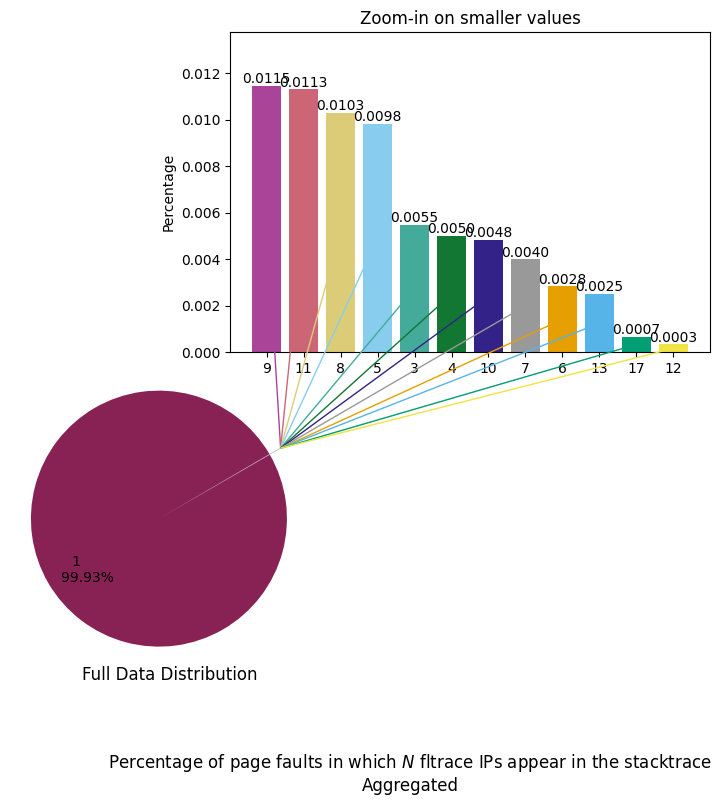

In [14]:
aggregated = pd.concat(all_groups, axis=1, join='outer').fillna(0).sum(axis=1)
aggregated = 100*aggregated/aggregated.sum()
aggregated_fig = plotter.get_pie_bar_zoom_in(aggregated.values,aggregated.index.to_numpy(dtype=str),
                                             fig_title=("Percentage of page faults in which $N$ fltrace IPs appear in the stacktrace"+f"\nAggregated"))
display(aggregated_fig)
plt.close()

It looks like there isn't one data page fault which didn't containt an fltrace IP in its stacktrace!

In [15]:
assert all(len(df[df["number_impacted_ips"] == 0]) == 0 for df in fltrace_impact_stats.values())

Let's look at when on average the first fltrace `ip` appears, grouping by the number of impacted ips

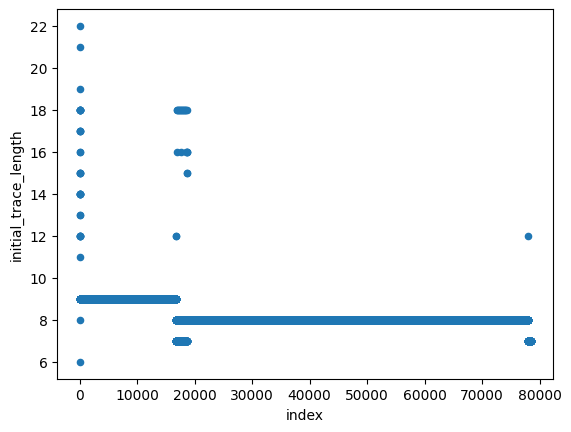

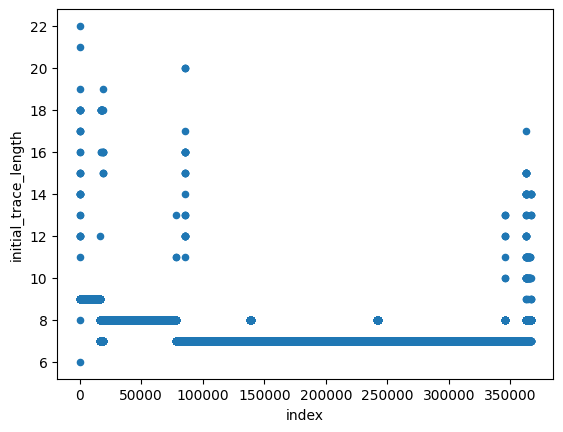

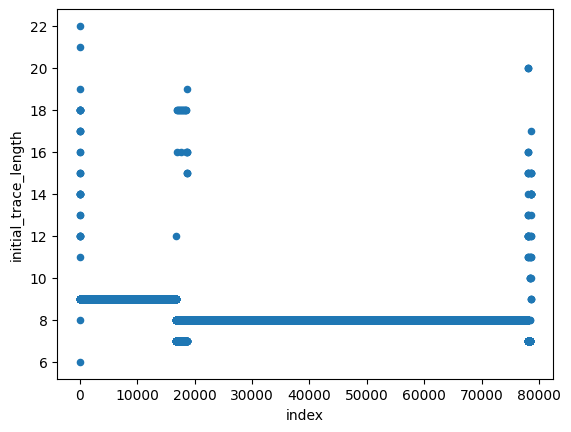

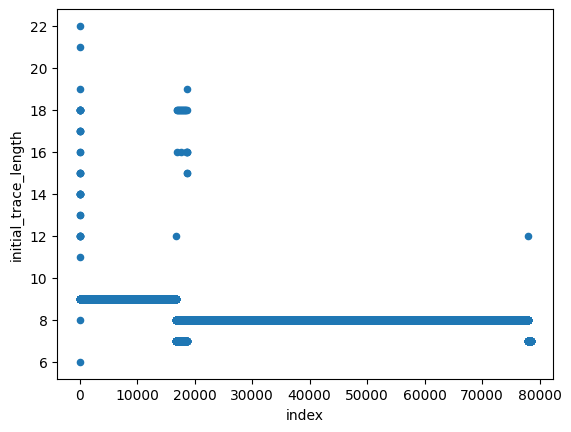

In [16]:
for runid,rs_df in fltrace_impact_stats.items():
    rs_df.reset_index().plot.scatter(x='index',y='initial_trace_length')

Now, let's take a look at the mean position of the ip in the stacktrace.

In [17]:
print("Get stats describing in which position the (faulty) instruction pointer is on average in the stacktrace")
for runid,df in all_dfs.items():
    print(runid)
    ip_pos_in_st = df[["ip","stacktrace"]].swifter.apply(lambda row: row.stacktrace.split('|').index(row.ip if row.ip.startswith("0x") else "0x"+row.ip) if row.ip in row.stacktrace else -1,axis=1)
    num_not_in_st = (ip_pos_in_st == -1).sum()
    print(num_not_in_st)
    print(ip_pos_in_st[ip_pos_in_st != -1].describe())
    print(TEXT_SEPARATOR)
    first_element_in_df =df.iloc[ip_pos_in_st[ip_pos_in_st != -1].index[0]]
    print(first_element_in_df.ip, '   ', first_element_in_df.stacktrace)
    print(TEXT_SEPARATOR)
    first_element_not_in_df =df.iloc[ip_pos_in_st[ip_pos_in_st == -1].index[0]]
    print(first_element_not_in_df.ip, '   ', first_element_not_in_df.stacktrace)
    print(TEXT_SEPARATOR)
    
    # For all `ip`s which aren't in the stacktrace, we heuristically simply add them at the end 
    df["stacktrace"] = df[["ip","stacktrace"]].swifter.apply(lambda row:(((row.ip if row.ip.startswith("0x") else "0x"+row.ip)+'|') if row.ip not in row.stacktrace else "")+row.stacktrace,axis=1)
    print(TEXT_SEPARATOR)
    print(TEXT_SEPARATOR)
    ip_pos_in_st = df[["ip","stacktrace"]].swifter.apply(lambda row: row.stacktrace.split('|').index(row.ip if row.ip.startswith("0x") else "0x"+row.ip) if row.ip in row.stacktrace else -1,axis=1)
    num_not_in_st = (ip_pos_in_st == -1).sum()
    print(num_not_in_st)
    print(TEXT_SEPARATOR)
    

Get stats describing in which position the (faulty) instruction pointer is on average in the stacktrace
fluidanimate_500_500_72968


Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

8
count    78395.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64
______________________________
5701b8390771     0x5701b8390771|0x5701b839087b|0x5701b838aab4|0x5701b838fd1b|0x734e6f829d90|0x734e6f829e40|0x5701b838a565
______________________________
734e6f9a0fa0     0x734e6fcaa93a|0x734e7354f47e|0x734e7354f568|0x734e735692ca
______________________________


Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

______________________________
______________________________


Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

0
______________________________
fluidanimate_500_125_71795


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

27
count    366205.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64
______________________________
62e728be2771     0x62e728be2771|0x62e728be287b|0x62e728bdcab4|0x62e728be1d1b|0x7047c0c29d90|0x7047c0c29e40|0x62e728bdc565
______________________________
7047c0da0fa0     0x7047c10aa93a|0x7047c489347e|0x7047c4893568|0x7047c48ad2ca
______________________________


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

______________________________
______________________________


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

0
______________________________
fluidanimate_500_250_72189


Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

21
count    78402.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64
______________________________
61fe999d0771     0x61fe999d0771|0x61fe999d087b|0x61fe999caab4|0x61fe999cfd1b|0x7bb841629d90|0x7bb841629e40|0x61fe999ca565
______________________________
7bb8417a0fa0     0x7bb841aaa93a|0x7bb8452c947e|0x7bb8452c9568|0x7bb8452e32ca
______________________________


Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

______________________________
______________________________


Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

0
______________________________
fluidanimate_500_375_72575


Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

8
count    78396.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64
______________________________
632b152cf771     0x632b152cf771|0x632b152cf87b|0x632b152c9ab4|0x632b152ced1b|0x723f7c229d90|0x723f7c229e40|0x632b152c9565
______________________________
723f7c3a0fa0     0x723f7c6aa93a|0x723f7fe3847e|0x723f7fe38568|0x723f7fe522ca
______________________________


Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

______________________________
______________________________


Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

0
______________________________


# II. Data analysis

Let's start by building the connection DAG, where a vertex is a position in code (instruction pointer) and an edge depicts an IP calling a different IP. That is, all sink vertices are instruction pointers causing a page fault.

In [18]:
import networkx as nx

In [19]:
analysis_df = list(all_dfs.values())[1]
analysis_df["ip_as_int"] = analysis_df["ip"].swifter.apply(lambda ip_str: int(ip_str,16))

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [25]:
def get_connection_graph(runid: RunIdentifier,df):
    g = nx.DiGraph()
    # First, add all ips = nodes
    well_formatted_ips = df["ip"].swifter.apply(lambda ip_str: (ip_str if ip_str.startswith("0x") else "0x"+ip_str))
    splitted_stacktrace_series = df["stacktrace"].swifter.apply(lambda stacktrace: stacktrace.split('|'))
    all_ips_from_stacktraces = splitted_stacktrace_series.explode(ignore_index=True)
    
    all_ips = pd.concat([well_formatted_ips,all_ips_from_stacktraces.rename("ip")],axis=0)
    ip_count_dict = all_ips.groupby(all_ips).count().to_dict()
    all_nodes_to_add = set(all_ips)
    assert  all_nodes_to_add == set(well_formatted_ips).union(all_ips_from_stacktraces)
    
    get_ip_lib = lambda ip: Path(extra_info[runid].libmap[ip]).name
    get_ip_count = lambda ip : ip_count_dict[ip]
    def get_node_attrs(ip):
        library = get_ip_lib(ip)
        count = get_ip_count(ip)
        return {'library':library,'count':count, 'size_for_viz':1+math.log10(count)}
    g.add_nodes_from(all_nodes_to_add)
    all_node_dicts = {node : get_node_attrs(node) for node in g.nodes}
    nx.set_node_attributes(g,all_node_dicts)

    # Then, simply add all the edges
    # An edge is of the form (u,v) = (from,to) = (src,dst)
    # --> reverse each stacktrace, zipped with itself shifted by 1
    def get_edges_from_staslist(st:list):
        reversed = st[::-1]
        two_grams = list(zip(reversed,reversed[1:]))
        return two_grams
    to_add = splitted_stacktrace_series.apply(get_edges_from_staslist).explode()#ignore_index = True)
    to_add = to_add.rename("edge")
    
    weights = to_add.groupby(to_add).count().to_dict()
    g.add_edges_from(to_add)
    def get_edge_attrs(uv):
        weight = weights[uv]
        return {'count':weight,'size_for_viz':1+math.log10(weight)}
    all_edge_dicts = {edge : get_edge_attrs(edge) for edge in g.edges}
    nx.set_edge_attributes(g,all_edge_dicts)
    return g

connection_graph = get_connection_graph(*list(all_dfs.items())[1])

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
# for runid,df in all_dfs.items():
#     runid: RunIdentifier
#     connection_graph = get_connection_graph(runid,df)
    #assert nx.is_directed_acyclic_graph(connection_graph)

assert list(all_dfs.items())[1][1].equals(analysis_df)
connection_graph = get_connection_graph(*list(all_dfs.items())[1])

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [22]:
connection_graph.number_of_edges()

123

In [102]:
sources =  [node for node, in_degree in connection_graph.in_degree() if in_degree == 0]
sinks = [node for node, out_degree in connection_graph.out_degree() if out_degree == 0]

all_paths = list(chain.from_iterable([[tuple(path) for path in nx.all_simple_paths(connection_graph,source,sinks)] for source in sources]))
all_paths_set = set(all_paths)
assert len(all_paths_set) == len(all_paths)


reversed_sts = {tuple(st.split('|')[::-1]) for st in analysis_df.stacktrace.unique()}
print(f"There are {len(all_paths_set.difference(reversed_sts))} paths which are never taken by the trace (no stacktrace goes through them). This is because there exist nodes with more than one outgoing edge, which then connect to other nodes with more than one outgoing edge. \n"
      f"e.g.: n1 -> A -> n2 -> C  ;  yet n1->B->n2->C is never taken, but it is tehcnically a valid path\n"
      f"         |->B -> n2 -> D")

print(f"There are {len(sinks)} sinks and {len(reversed_sts)} stacktraces.")

There are 5 paths which are never taken by the trace (no stacktrace goes through them). This is because there exist nodes with more than one outgoing edge, which then connect to other nodes with more than one outgoing edge. 
e.g.: n1 -> A -> n2 -> C  ;  yet n1->B->n2->C is never taken, but it is tehcnically a valid path
         |->B -> n2 -> D
There are 56 sinks and 65 stacktraces.


## Adding back the time dimension - per-path grouping 

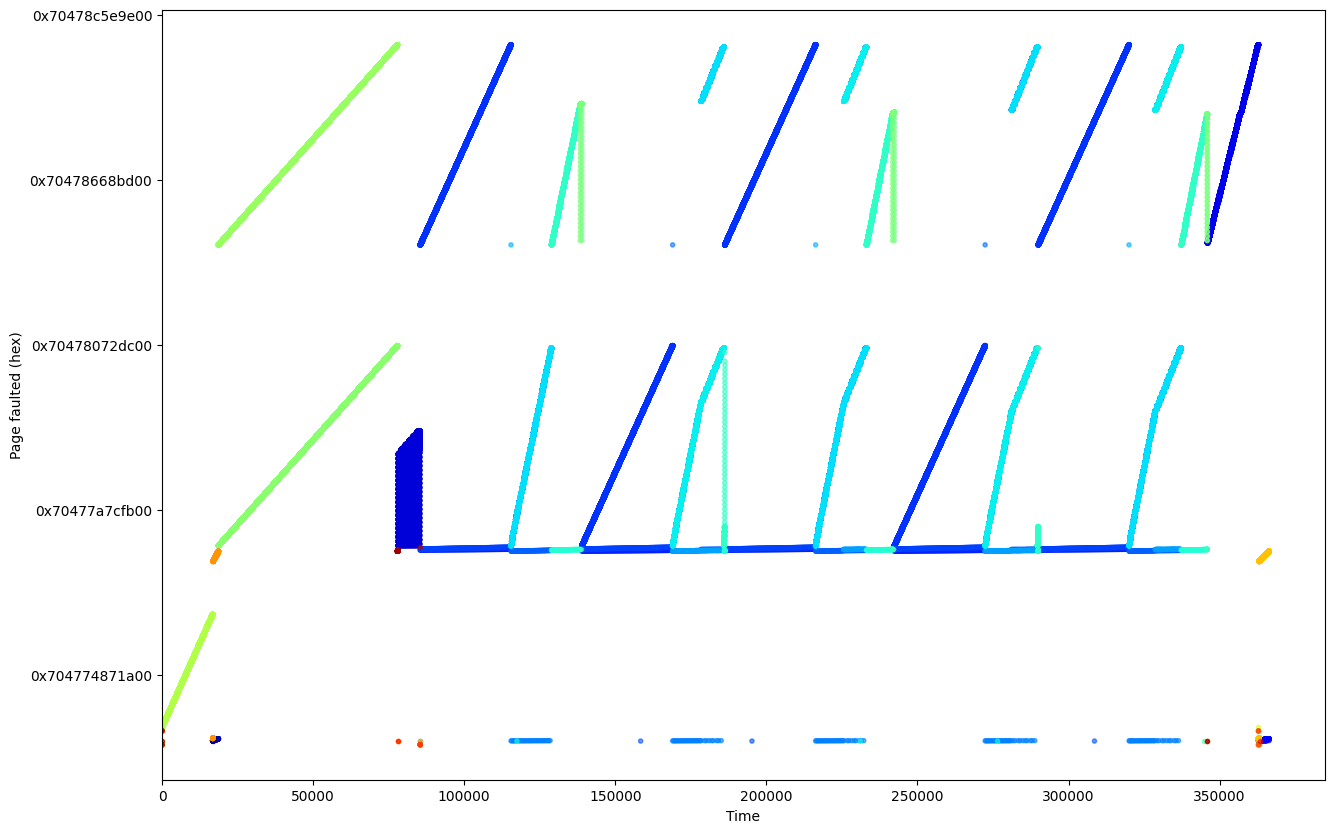

In [110]:

start_point = analysis_df["tstamp"].min()
analysis_df["relative_tstamp"] = analysis_df["tstamp"].apply(lambda t: t-start_point)

PAGE_SIZE = 4 * 1024

grouped_addresses = pd.concat([analysis_df.groupby("stacktrace")["addr"].apply(list).rename("pages").apply(lambda addr_list: [int(addr,16) & ~(PAGE_SIZE-1)  for addr in addr_list]),analysis_df.groupby("stacktrace").size().rename("num_occurrences"),analysis_df.reset_index().groupby("stacktrace")["index"].apply(list).rename("index_occurrences")],axis=1).reset_index()

import matplotlib.ticker as ticker
import numpy as np

def get_time_graph(df):
    fig,ax = plt.subplots(figsize=(15,10))
    assert len(df) == len(df["stacktrace"].unique())
    num_groups = len(df)
    cmap = plt.cm.jet(np.linspace(0,1,num_groups))
    
    for i,row in df.iterrows():
        ax.scatter(row["index_occurrences"],row["pages"],color=[cmap[i]]*len(row["pages"]),alpha=0.6, label=row["stacktrace"],marker='.')
    #fig.legend(title="Groups")
    ax.set_xlabel('Time')
    current_xlims = ax.get_xlim()
    ax.set_xlim([0,current_xlims[-1]])
    ax.set_ylabel('Page faulted (hex)')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x,pos: hex(int(x))))
    return fig,ax
plt.ioff()
fig,axs = get_time_graph(grouped_addresses)
plt.ion()
display(fig)

In [147]:
# Exclude the mandatory page faults:
MANDATORY_FLAG = 32
mandatory_page_faults_mask = analysis_df["flags"] >= MANDATORY_FLAG
print(f"Out of the {len(analysis_df)} page faults, {mandatory_page_faults_mask.sum()} are mandatory faults.")
analysis_without_mandatory = analysis_df[~mandatory_page_faults_mask]
print(f"Removing them leads us with {len(analysis_without_mandatory['stacktrace'].unique())} (down from {len(analysis_df['stacktrace'].unique())}) unique paths taken by the application.")

grouped_no_mandatory = pd.concat([analysis_without_mandatory.groupby("stacktrace")["addr"].apply(list).rename("pages").apply(lambda addr_list: [int(addr,16) & ~(PAGE_SIZE-1)  for addr in addr_list]),analysis_without_mandatory.groupby("stacktrace").size().rename("num_occurrences"),analysis_without_mandatory.reset_index().groupby("stacktrace")["index"].apply(list).rename("index_occurrences"),analysis_without_mandatory.groupby("stacktrace")["regs"].apply(lambda registers: [hex(reg) for reg in registers.split('!')])],axis=1).reset_index()

plt.ioff()
fig,ax = get_time_graph(grouped_no_mandatory)
plt.ion()
display(fig)


Out of the 366232 page faults, 78407 are mandatory faults.
Removing them leads us with 48 (down from 65) unique paths taken by the application.


AttributeError: 'Series' object has no attribute 'split'

In [146]:
mask_interesting = pd.concat([grouped_no_mandatory,grouped_no_mandatory["stacktrace"].apply(lambda st: st.split('|')[0]).rename("ip")],axis=1)
#mask_interesting["ip"].sort_values()

mask_interesting[mask_interesting["ip"] == "0x7047c0c98ec1"][["pages","index_occurrences"]].apply(lambda row: (row.index_occurrences[:3],','.join([hex(page) for page in row.pages])),axis=1)



40    ([362863, 362881, 362884], 0x704772008000,0x70...
41    ([362841, 362847], 0x704772805000,0x704772807000)
42    ([85433, 85435, 85437], 0x704772008000,0x70477...
dtype: object

In [135]:
grouped_no_mandatory[grouped_no_mandatory["index_occurrences"].apply(lambda lst_indices : sorted(lst_indices)) #.apply(lambda row: (row.index_occurrences[:3],','.join([hex(page) for page in row.pages])),axis=1)


SyntaxError: incomplete input (4007519216.py, line 2)

In [130]:
analysis_df[analysis_df.index.isin([115477,115478,115479])]

,tstamp,ip,addr,flags,regs,stacktrace,ip_as_int,relative_tstamp
115477,1.728159e+09,62e728bded08,704778fe0000,0,140736299714528!123453479405520!0!123451140474...,0x62e728bded08|0x62e728be1a82|0x62e728be1b71|0...,108744960503048,1.372738
115478,1.728159e+09,62e728bded3e,704779300000,0,140736299714528!123453479405520!0!123451140474...,0x62e728bded3e|0x62e728be1a82|0x62e728be1b71|0...,108744960503102,1.372743
115479,1.728159e+09,62e728bdee9c,70477223d000,0,140736299714528!123453479405520!0!123451140474...,0x62e728bdee9c|0x62e728be1a82|0x62e728be1b71|0...,108744960503452,1.372749


In [105]:
def get_group_figure(df,group):
    

plt.ioff()
all_group_figures = []
for 
plt.ion()